In [ ]:
# Projt 1 of MATH6380O, Spring 2018
# In this project, we firstly train a model for the classification of SVHN dataset, then try to transfer it into MNIST dataset.
#
# Ng Ka Chung (SID: 20097188), LO Yi-Su (SID: 20399988)
# Contact: yloab@ust.hk
#
# P.S. There is another document for another dataset. 

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
use_gpu = torch.cuda.is_available()

plt.ion()   # interactive mode

In [2]:
# Build Dataloader for MNIST and SVHN dataset
batch_size = 100
log_interval = 10


# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([transforms.Resize(32), 
                                      transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor(), 
                                      transforms.Normalize((0.5,), (0.5,))])

# MNIST
mnist_path = 'MNIST_data'
mnist_datasets = {'train': datasets.MNIST(mnist_path, train=True, transform=data_transforms, download=True)}
mnist_datasets['val'] = datasets.MNIST(mnist_path, train=False, transform=data_transforms)

mnist_loaders = {x: torch.utils.data.DataLoader(mnist_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
mnist_sizes = {x: len(mnist_datasets[x]) for x in ['train', 'val']}

# SVHN
svhn_path = 'SVHN_data'
svhn_datasets = {'train': datasets.SVHN(svhn_path, split='train', transform=data_transforms, download=True)}
svhn_datasets['val'] = datasets.SVHN(svhn_path, split='test', transform=data_transforms, download=True)

svhn_loaders = {x: torch.utils.data.DataLoader(svhn_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
svhn_sizes = {x: len(svhn_datasets[x]) for x in ['train', 'val']}

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Using downloaded and verified file: SVHN_data\train_32x32.mat
Using downloaded and verified file: SVHN_data\test_32x32.mat


In [3]:
print(mnist_sizes)
print(svhn_sizes)

{'train': 60000, 'val': 10000}
{'train': 73257, 'val': 26032}


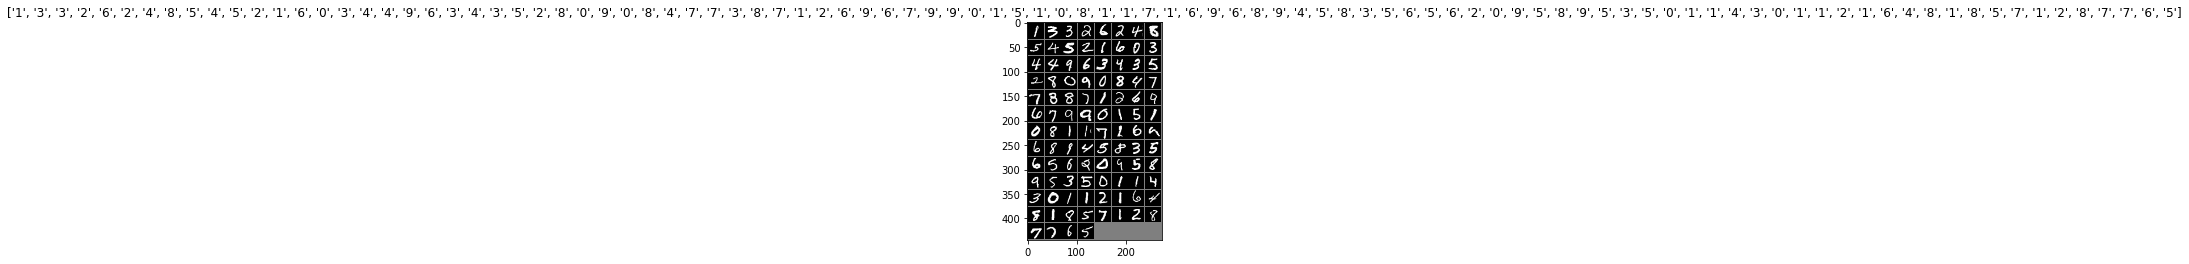

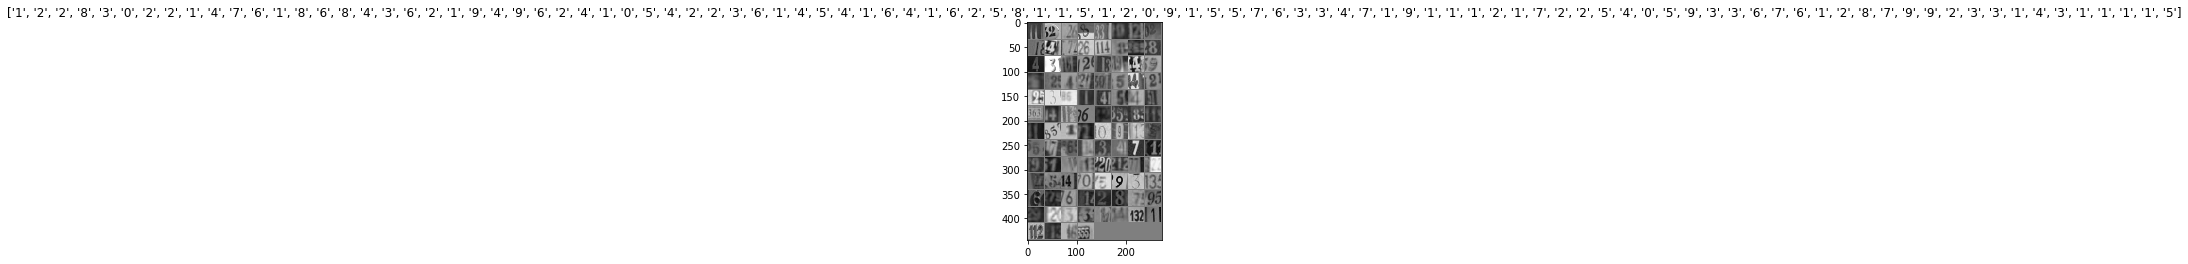

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.grid(False)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(mnist_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(svhn_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
# Define Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(20, 40, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.maxpool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(6*6*40, 10)
        #self.relu3= nn.ReLU()
        #self.dropout = nn.Dropout()
        #self.fc2 = nn.Linear(200, 10)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.relu2(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = self.maxpool2(x)
        x = self.relu2(x)
        x = x.view(-1, 6*6*40)
        x = self.fc(x)
        #x = self.relu3(x)
        #x = self.dropout(x)
        #x = self.fc2(x)
        x = self.logsoftmax(x)
        
        return x
    
# Training function
def train_model(model, datasets, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    if datasets == 'svhn':
        dataloaders = svhn_loaders
        datasets_sizes = svhn_sizes
    else:
        dataloaders = mnist_loaders
        datasets_sizes = mnist_sizes
        
    loss_epoch = np.zeros((num_epochs, num_epochs))
        
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / datasets_sizes[phase]
            epoch_acc = running_corrects / datasets_sizes[phase]

            if phase == 'train':
                loss_epoch[epoch][0] = epoch_loss
            else:
                loss_epoch[epoch][1] = epoch_loss                
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_epoch

# Results evaluation
def visualize_model(model, datasets, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    if datasets == 'svhn':
        dataloaders = svhn_loaders
    else:
        dataloaders = mnist_loaders  
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [6]:
#Obtain the pre-trained model based on svhn
model_svhn = Net()

if use_gpu:
    model_svhn = model_svhn.cuda()

# Observe that all parameters are being optimized
optimizer_svhn = optim.SGD(model_svhn.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_svhn = lr_scheduler.StepLR(optimizer_svhn, step_size=7, gamma=0.1)

In [7]:
criterion = nn.CrossEntropyLoss()

model_svhn, loss_svhn = train_model(model_svhn, 'svhn', criterion, optimizer_svhn, exp_lr_scheduler_svhn,
                       num_epochs=500)

Epoch 0/499
----------
train Loss: 2.2429 Acc: 0.1862
val Loss: 2.2156 Acc: 0.1960

Epoch 1/499
----------
train Loss: 2.2161 Acc: 0.1966
val Loss: 2.1762 Acc: 0.2054

Epoch 2/499
----------
train Loss: 2.1250 Acc: 0.2544
val Loss: 1.9755 Acc: 0.3624

Epoch 3/499
----------
train Loss: 1.8111 Acc: 0.4183
val Loss: 1.4986 Acc: 0.5659

Epoch 4/499
----------
train Loss: 1.4057 Acc: 0.5715
val Loss: 1.1640 Acc: 0.6926

Epoch 5/499
----------
train Loss: 1.1622 Acc: 0.6580
val Loss: 0.9798 Acc: 0.7394

Epoch 6/499
----------
train Loss: 1.0271 Acc: 0.7044
val Loss: 0.8873 Acc: 0.7629

Epoch 7/499
----------
train Loss: 0.9631 Acc: 0.7237
val Loss: 0.8745 Acc: 0.7706

Epoch 8/499
----------
train Loss: 0.9520 Acc: 0.7270
val Loss: 0.8665 Acc: 0.7729

Epoch 9/499
----------
train Loss: 0.9465 Acc: 0.7297
val Loss: 0.8606 Acc: 0.7741

Epoch 10/499
----------
train Loss: 0.9367 Acc: 0.7328
val Loss: 0.8514 Acc: 0.7768

Epoch 11/499
----------
train Loss: 0.9316 Acc: 0.7330
val Loss: 0.8473 Acc

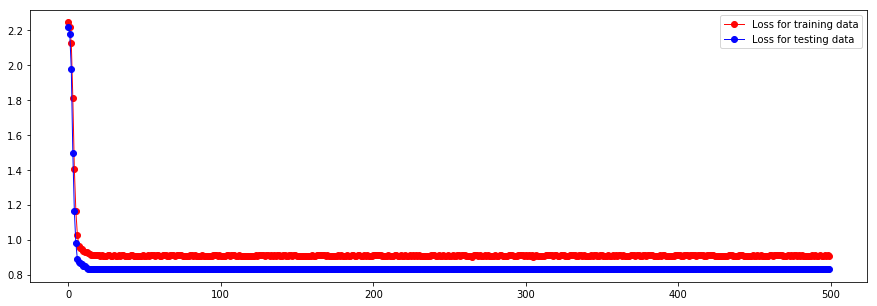

In [8]:
# Loss plot
plt.figure(figsize=(15, 5))
plt.plot(loss_svhn.T[0], lw=1, color="red", alpha=10, marker='o', label='Loss for training data');
plt.plot(loss_svhn.T[1], lw=1, color="blue", alpha=10, marker='o', label='Loss for testing data');
#plt.axhline(y=0, lw=1, color="r", alpha=0.5, linestyle='-.')
plt.legend()
fig = plt.gcf()
#fig.savefig('rho_plot.png')

## **Model 1 for MNIST: Without Transfer Learning **

In [9]:
model_1 = Net()

if use_gpu:
    model_1 = model_1.cuda()

# Observe that all parameters are being optimized
optimizer_1 = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_1 = lr_scheduler.StepLR(optimizer_1, step_size=7, gamma=0.1)

In [10]:
model_1, loss_1 = train_model(model_1, 'mnist', criterion, optimizer_1, exp_lr_scheduler_1,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.9190 Acc: 0.7538
val Loss: 0.3188 Acc: 0.9099

Epoch 1/49
----------
train Loss: 0.3341 Acc: 0.9052
val Loss: 0.2272 Acc: 0.9362

Epoch 2/49
----------
train Loss: 0.2576 Acc: 0.9269
val Loss: 0.1774 Acc: 0.9491

Epoch 3/49
----------
train Loss: 0.2117 Acc: 0.9396
val Loss: 0.1428 Acc: 0.9587

Epoch 4/49
----------
train Loss: 0.1806 Acc: 0.9486
val Loss: 0.1214 Acc: 0.9637

Epoch 5/49
----------
train Loss: 0.1590 Acc: 0.9546
val Loss: 0.1091 Acc: 0.9688

Epoch 6/49
----------
train Loss: 0.1480 Acc: 0.9573
val Loss: 0.0969 Acc: 0.9713

Epoch 7/49
----------
train Loss: 0.1367 Acc: 0.9603
val Loss: 0.0962 Acc: 0.9728

Epoch 8/49
----------
train Loss: 0.1349 Acc: 0.9613
val Loss: 0.0951 Acc: 0.9724

Epoch 9/49
----------
train Loss: 0.1346 Acc: 0.9613
val Loss: 0.0943 Acc: 0.9731

Epoch 10/49
----------
train Loss: 0.1329 Acc: 0.9624
val Loss: 0.0938 Acc: 0.9724

Epoch 11/49
----------
train Loss: 0.1308 Acc: 0.9617
val Loss: 0.0929 Acc: 0.9728

Ep

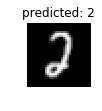

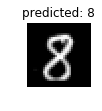

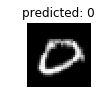

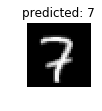

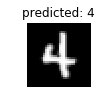

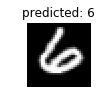

In [11]:
visualize_model(model_1, 'mnist')

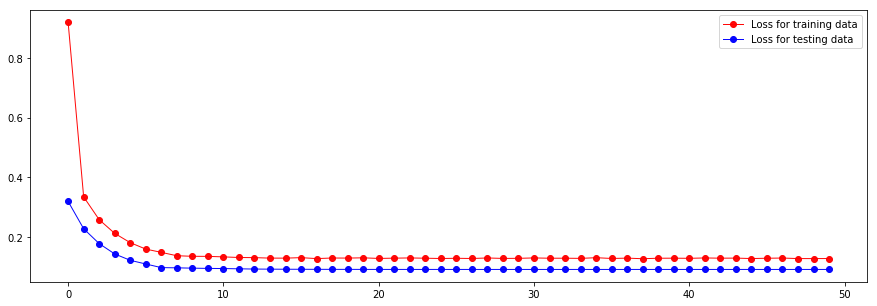

In [12]:
# Loss plot
plt.figure(figsize=(15, 5))
plt.plot(loss_1.T[0], lw=1, color="red", alpha=10, marker='o', label='Loss for training data');
plt.plot(loss_1.T[1], lw=1, color="blue", alpha=10, marker='o', label='Loss for testing data');
#plt.axhline(y=0, lw=1, color="r", alpha=0.5, linestyle='-.')
plt.legend()
fig = plt.gcf()
#fig.savefig('rho_plot.png')

## **Model 2 for MNIST: Fine-tune Fully Connected Layers **

In [13]:
#Apply the pre-trained model on mnist
model_2 = model_svhn
num_ftrs = model_2.fc.in_features
model_2.fc = nn.Linear(num_ftrs, 10)

if use_gpu:
    model_2 = model_2.cuda()

# Observe that all parameters are being optimized
optimizer_2 = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_2 = lr_scheduler.StepLR(optimizer_2, step_size=7, gamma=0.1)

In [14]:
model_2, loss_2 = train_model(model_2, 'mnist', criterion, optimizer_2, exp_lr_scheduler_2,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 0.2835 Acc: 0.9159
val Loss: 0.1083 Acc: 0.9692

Epoch 1/49
----------
train Loss: 0.1542 Acc: 0.9546
val Loss: 0.0887 Acc: 0.9725

Epoch 2/49
----------
train Loss: 0.1341 Acc: 0.9603
val Loss: 0.0746 Acc: 0.9768

Epoch 3/49
----------
train Loss: 0.1206 Acc: 0.9644
val Loss: 0.0733 Acc: 0.9765

Epoch 4/49
----------
train Loss: 0.1120 Acc: 0.9666
val Loss: 0.0671 Acc: 0.9796

Epoch 5/49
----------
train Loss: 0.1042 Acc: 0.9690
val Loss: 0.0676 Acc: 0.9796

Epoch 6/49
----------
train Loss: 0.0991 Acc: 0.9701
val Loss: 0.0615 Acc: 0.9826

Epoch 7/49
----------
train Loss: 0.0924 Acc: 0.9727
val Loss: 0.0587 Acc: 0.9831

Epoch 8/49
----------
train Loss: 0.0925 Acc: 0.9721
val Loss: 0.0587 Acc: 0.9832

Epoch 9/49
----------
train Loss: 0.0910 Acc: 0.9735
val Loss: 0.0572 Acc: 0.9829

Epoch 10/49
----------
train Loss: 0.0890 Acc: 0.9740
val Loss: 0.0575 Acc: 0.9831

Epoch 11/49
----------
train Loss: 0.0873 Acc: 0.9742
val Loss: 0.0569 Acc: 0.9837

Ep

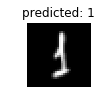

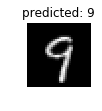

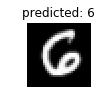

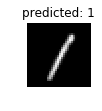

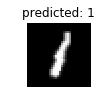

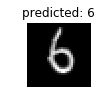

In [15]:
visualize_model(model_2, 'mnist')

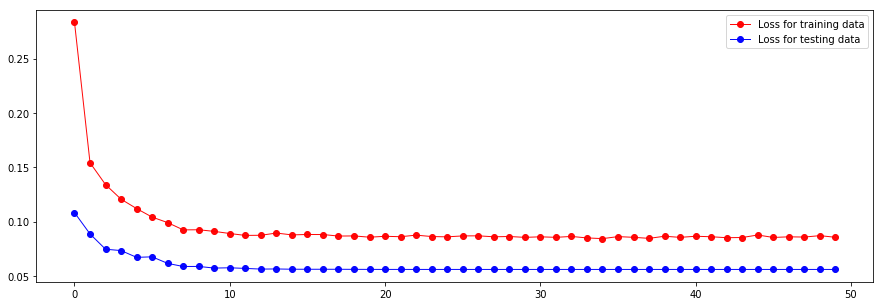

In [16]:
# Loss plot
plt.figure(figsize=(15, 5))
plt.plot(loss_2.T[0], lw=1, color="red", alpha=10, marker='o', label='Loss for training data');
plt.plot(loss_2.T[1], lw=1, color="blue", alpha=10, marker='o', label='Loss for testing data');
#plt.axhline(y=0, lw=1, color="r", alpha=0.5, linestyle='-.')
plt.legend()
fig = plt.gcf()
#fig.savefig('rho_plot.png')

## **Model 3 for MNIST: Freeze Model Parameters **

In [17]:
model_3 = model_svhn.eval()
for param in model_3.parameters():
    param.requires_grad = False

num_ftrs = model_3.fc.in_features
model_3.fc = nn.Linear(num_ftrs, 10)

if use_gpu:
    model_3 = model_3.cuda()

# Observe that only parameters of final 2 layers are being optimized as
# opoosed to before.
optimizer_3 = optim.SGD(model_3.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_3 = lr_scheduler.StepLR(optimizer_3, step_size=7, gamma=0.1)

In [18]:
#Apply the pre-trained model on mnist
model_3, loss_3 = train_model(model_3, 'mnist', criterion, optimizer_3,
                         exp_lr_scheduler_3, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.2518 Acc: 0.9238
val Loss: 0.0977 Acc: 0.9716

Epoch 1/49
----------
train Loss: 0.1349 Acc: 0.9599
val Loss: 0.0776 Acc: 0.9771

Epoch 2/49
----------
train Loss: 0.1197 Acc: 0.9649
val Loss: 0.0681 Acc: 0.9792

Epoch 3/49
----------
train Loss: 0.1098 Acc: 0.9675
val Loss: 0.0641 Acc: 0.9799

Epoch 4/49
----------
train Loss: 0.1032 Acc: 0.9695
val Loss: 0.0619 Acc: 0.9804

Epoch 5/49
----------
train Loss: 0.1000 Acc: 0.9698
val Loss: 0.0609 Acc: 0.9811

Epoch 6/49
----------
train Loss: 0.0952 Acc: 0.9712
val Loss: 0.0563 Acc: 0.9830

Epoch 7/49
----------
train Loss: 0.0899 Acc: 0.9735
val Loss: 0.0554 Acc: 0.9827

Epoch 8/49
----------
train Loss: 0.0880 Acc: 0.9739
val Loss: 0.0549 Acc: 0.9829

Epoch 9/49
----------
train Loss: 0.0879 Acc: 0.9746
val Loss: 0.0546 Acc: 0.9838

Epoch 10/49
----------
train Loss: 0.0877 Acc: 0.9740
val Loss: 0.0540 Acc: 0.9839

Epoch 11/49
----------
train Loss: 0.0878 Acc: 0.9744
val Loss: 0.0541 Acc: 0.9837

Ep

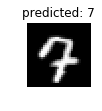

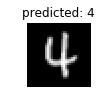

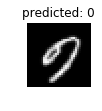

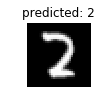

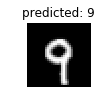

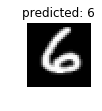

In [19]:
visualize_model(model_3, 'mnist')

plt.ioff()
plt.show()

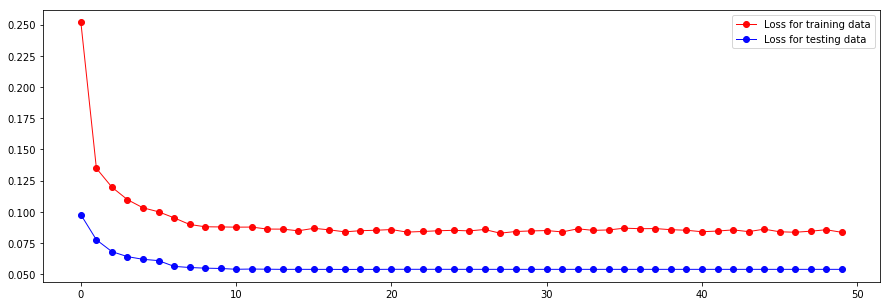

In [20]:
# Loss plot
plt.figure(figsize=(15, 5))
plt.plot(loss_3.T[0], lw=1, color="red", alpha=10, marker='o', label='Loss for training data');
plt.plot(loss_3.T[1], lw=1, color="blue", alpha=10, marker='o', label='Loss for testing data');
#plt.axhline(y=0, lw=1, color="r", alpha=0.5, linestyle='-.')
plt.legend()
fig = plt.gcf()
#fig.savefig('rho_plot.png')

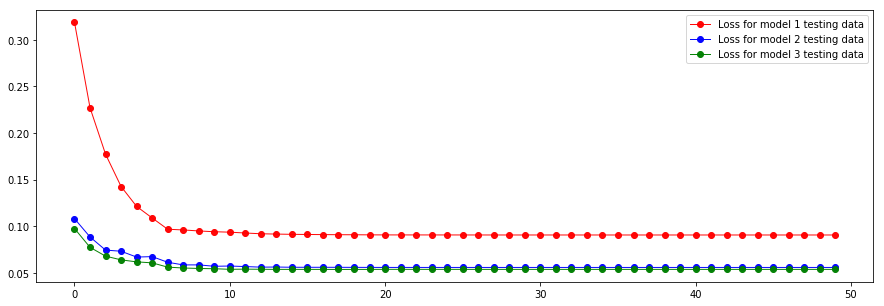

In [21]:
# Overall Loss plot
plt.figure(figsize=(15, 5))
plt.plot(loss_1.T[1], lw=1, color="red", alpha=10, marker='o', label='Loss for model 1 testing data');
plt.plot(loss_2.T[1], lw=1, color="blue", alpha=10, marker='o', label='Loss for model 2 testing data');
plt.plot(loss_3.T[1], lw=1, color="green", alpha=10, marker='o', label='Loss for model 3 testing data');
plt.legend()
fig = plt.gcf()

## **Feature Representation By Manifold Learning **

In [22]:
model_ft = model_svhn.eval()
if use_gpu:
    model_ft=model_ft.cuda()
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

1440


In [23]:
print(model_ft)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (relu1): ReLU()
  (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (relu2): ReLU()
  (fc): Linear(in_features=1440, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)


In [25]:
modules = list(model_ft.children())[:-3]
shvn_feature = nn.Sequential(*modules)

features_train=[]
features_val=[]
classes_train=[]
classes_val=[]
for data in ['train','val']:
    for i,(images,labels) in enumerate(mnist_loaders[data]):
        img=Variable(images)
        if use_gpu:
            img=img.cuda()
        out=shvn_feature.forward(img)
        out=out.view(-1, 6*6*40).cpu().data.numpy()
        #out=out.cpu().data.numpy()
        labels=labels.numpy()
        if data=='train':
            features_train.append(out)
            classes_train.append(labels)
        else:
            features_val.append(out)
            classes_val.append(labels)
features_train=np.vstack(features_train)
classes_train=np.hstack(classes_train)
features_val=np.vstack(features_val)
classes_val=np.hstack(classes_val)

print('train features size:{}\tlabels size:{}'.format(features_train.shape,classes_train.shape))
print('val features size:{}\tlabels size:{}'.format(features_val.shape,classes_val.shape))

train features size:(60000, 1440)	labels size:(60000,)
val features size:(10000, 1440)	labels size:(10000,)


Here, we compare 8 popular methods in Manifold Learning:

PCA,Isomap,MDA,tSNE,LLE,LTSA,Hessian LLE,Modified LLE

PCA starts......
TSNE starts......


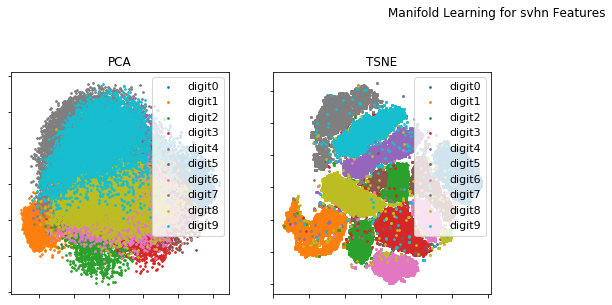

In [26]:
import seaborn
from matplotlib.ticker import NullFormatter
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap,MDS,TSNE,LocallyLinearEmbedding,SpectralEmbedding

LLE_dict=dict(zip(['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE'],
                    ['standard', 'ltsa', 'hessian', 'modified']))
#methods=['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE','Isomap','MDS','TSNE','PCA']
methods=['PCA', 'TSNE']

fig_features=plt.figure(1,figsize=(18,9))
fig_features.suptitle('Manifold Learning for svhn Features')

for i,method in enumerate(methods):
    print('{} starts......'.format(method))
    if method in LLE_dict.keys():
        manifold=LocallyLinearEmbedding(n_neighbors=6,method=LLE_dict[method],eigen_solver='dense')
    elif method=='MDS':
        manifold=MDS(n_init=1,max_iter=100)
    elif method=='PCA':
        exec('manifold={}(n_components=2)'.format(method))
    elif method=='TSNE':
        exec('manifold={}(n_components=2,init="pca")'.format(method))
    else:
        exec('manifold={}(n_neighbors=6)'.format(method))
    features_2D=manifold.fit_transform(features_train)
    np.save('features_2d_{}'.format(method),features_2D)
    
    ax=fig_features.add_subplot(241+i)
    
    ax.scatter(features_2D[np.where(classes_train==0),0],features_2D[np.where(classes_train==0),1],s=3,c='tab:blue',label='digit0')
    ax.scatter(features_2D[np.where(classes_train==1),0],features_2D[np.where(classes_train==1),1],s=3,c='tab:orange',label='digit1')
    ax.scatter(features_2D[np.where(classes_train==2),0],features_2D[np.where(classes_train==2),1],s=3,c='tab:green',label='digit2')
    ax.scatter(features_2D[np.where(classes_train==3),0],features_2D[np.where(classes_train==3),1],s=3,c='tab:red',label='digit3')
    ax.scatter(features_2D[np.where(classes_train==4),0],features_2D[np.where(classes_train==4),1],s=3,c='tab:purple',label='digit4')
    ax.scatter(features_2D[np.where(classes_train==5),0],features_2D[np.where(classes_train==5),1],s=3,c='tab:brown',label='digit5')
    ax.scatter(features_2D[np.where(classes_train==6),0],features_2D[np.where(classes_train==6),1],s=3,c='tab:pink',label='digit6')
    ax.scatter(features_2D[np.where(classes_train==7),0],features_2D[np.where(classes_train==7),1],s=3,c='tab:gray',label='digit7')
    ax.scatter(features_2D[np.where(classes_train==8),0],features_2D[np.where(classes_train==8),1],s=3,c='tab:olive',label='digit8')
    ax.scatter(features_2D[np.where(classes_train==9),0],features_2D[np.where(classes_train==9),1],s=3,c='tab:cyan',label='digit9')
    
    ax.legend(loc='upper right',prop={'size':11})
    ax.set_title(method)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    
fig_features.savefig('Manifold_of_svhn.png')


Now we test some traditional Machine Learning methods such Logistic Regression and SVM by using the svhn features.

Then we can make a comparion between Machine Learning and Deep Learning.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.metrics import accuracy_score


accuracy_train=[]
accuracy_val=[]
for method in ['LogisticRegression','LinearSVC']:
    print('%s starts...' % method)
    if method=='LogisticRegression':
        exec('transformation=%s(penalty="l2")' % method)
    else:
        exec('transformation=%s(penalty="l2")' % method)
    transformation.fit(features_train,classes_train)
    pred_train=transformation.predict(features_train)
    pred_val=transformation.predict(features_val)
    accuracy_train.append(accuracy_score(classes_train,pred_train))
    accuracy_val.append(accuracy_score(classes_val,pred_val))
    print('training accuracy:{:.4f}\t val accuracy:{:.4f}'.format(accuracy_train[-1],accuracy_val[-1]))


LogisticRegression starts...
training accuracy:0.9997	 val accuracy:0.9834
LinearSVC starts...
training accuracy:0.9999	 val accuracy:0.9812
